# Integration with Business Processes

In [1]:
import pandas as pd
from rdflib import Graph
import networkx as nx
from matplotlib import pyplot as plt
from netgraph import Graph as NetGraph

from helper import rdf_to_nx

In [2]:
api_kg = Graph()
api_kg = api_kg.parse("ro_shared_data/api_knowledge_graph.ttl", 
                      format="turtle")
print(f"API KG size: {len(api_kg)} triples")

API KG size: 14942 triples


In [3]:
process_kg = Graph()
process_kg = process_kg.parse('ro_shared_data/business_processes.ttl',
                              format='turtle')
print(f"Business Process Graph size: {len(process_kg)} triples.")

Business Process Graph size: 146 triples.


In [4]:
process_query = """
PREFIX pr: <http://example.org/process#>
SELECT ?name 
WHERE {
    ?process a pr:Process .
    ?process pr:name ?name .
}
"""
results = process_kg.query(process_query)
print("Processes:")
for row in results:
    print(f"- {row.name}")

Processes:
- Procurement of Direct Materials
- Sell from Stock
- External Transportation Planning
- Service Contract Management
- Customer Returns with Direct Shipment from Customer to Supplier
- Warehouse Inbound Processing
- Project Billing – Project-Based Services
- Inbound Delivery Management


## Integrating the Business Process Graph

In [5]:
kg = Graph()
kg = api_kg + process_kg
print(f"Combined Knowledge Graph size: {len(kg)} triples.")

Combined Knowledge Graph size: 15088 triples.


In [6]:
kg.serialize(destination='odata_knowledge_graph.ttl', format='turtle')

<Graph identifier=N8aad3b2eaf584928a140dc303f4147d6 (<class 'rdflib.graph.Graph'>)>

In [7]:
connect_query = """
PREFIX odata: <http://example.org/odata#>
PREFIX pr: <http://example.org/process#>
SELECT DISTINCT ?activityName ?entitySetName ?serviceName
{
    ?process a pr:Process .
    ?process pr:name "Procurement of Direct Materials" .
    ?process pr:start ?activity .
    ?activity a pr:Activity .
    ?activity pr:hasNext* ?nextActivity .
    ?nextActivity a pr:Activity .
    ?nextActivity pr:name ?activityName .
    ?nextActivity pr:entitySet ?entity_set.
    ?entity_set a odata:EntitySet .
    ?entity_set odata:name ?entitySetName .
    ?entity_set odata:entityType/odata:service ?service .
    ?service odata:name ?serviceName  .
}
"""
results = kg.query(connect_query)
for row in results:
    print(f"Activity '{row.activityName}' is connected to " + 
          f"Entity Set '{row.entitySetName}' in " +
          f"Service '{row.serviceName}'.")

Activity 'Create Purchase Requisition' is connected to Entity Set 'PurchaseReqn' in Service 'API_PURCHASEREQUISITION_2'.
Activity 'Create Purchase Order' is connected to Entity Set 'PurchaseOrder' in Service 'API_PURCHASEORDER_2'.


## Visualizing the connected graph

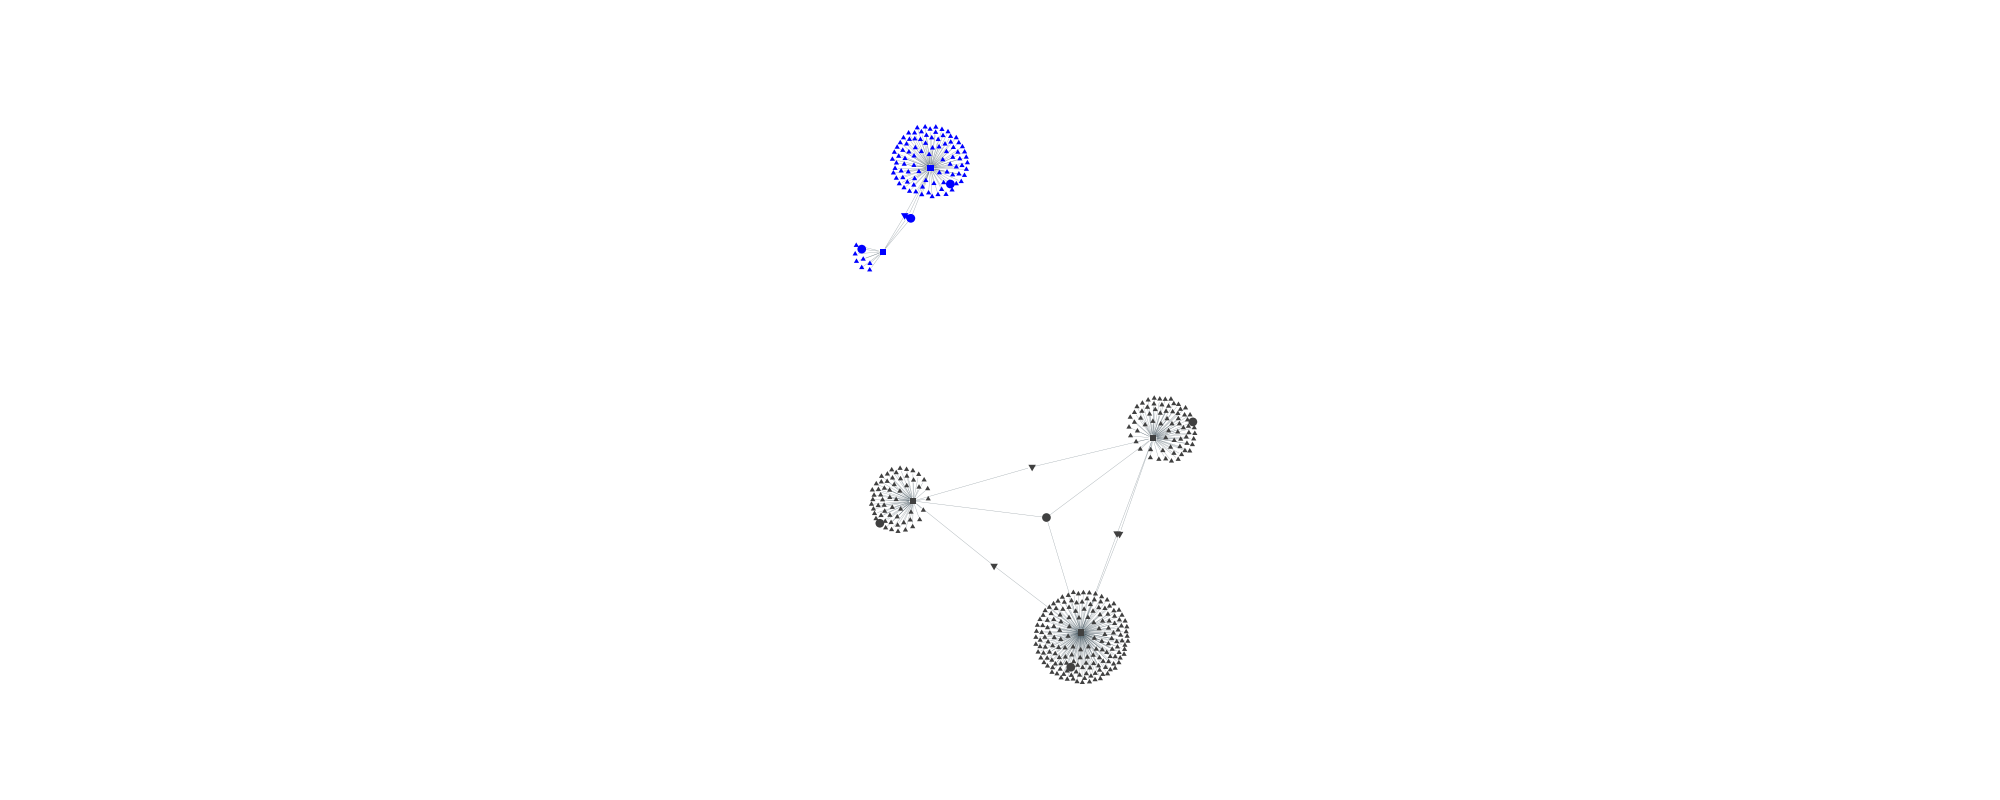

In [8]:
from IPython.display import Image
Image(filename='ro_shared_data/api_graph_example.png')

In [9]:
find_entity_set_query = """
PREFIX odata: <http://example.org/odata#>
SELECT ?uri ?name
{{
    ?uri a odata:EntitySet .
    ?uri odata:name ?name .
    FILTER(?name = "{name}")
}}
LIMIT 1
"""
# Get Purchase order entity set
for res in kg.query(find_entity_set_query.format(name="PurchaseOrder")):
    PO_node = str(res.uri)
    print(f"URI of the Purchase order entity set:\n{PO_node}")

URI of the Purchase order entity set:
http://data.example.org/Service/API_PURCHASEORDER_2/EntitySet/PURCHASEORDER


In [10]:
G = rdf_to_nx(kg)
G_po = G.subgraph(nx.shortest_path(G, PO_node))

In [11]:
import warnings # Ignore harmless NetGraph warning from zero-length edge normalization
warnings.filterwarnings("ignore", message="invalid value encountered in divide", module="netgraph")

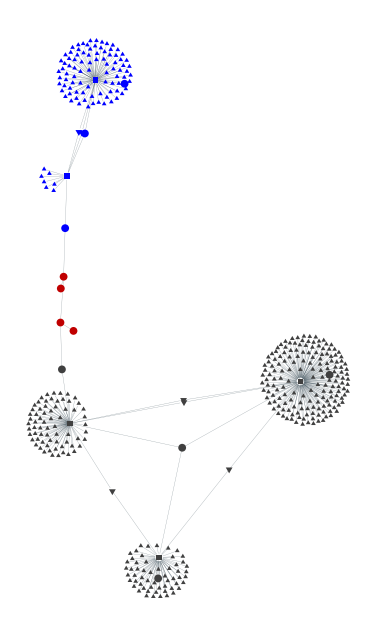

In [12]:
node_color = {}
for node in G_po:
    if "API_PURCHASEORDER_2" in node:
        node_color[node] = "#404040"
    elif "API_PURCHASEREQUISITION_2" in node:
        node_color[node] = "#0000FF"
    else:
        node_color[node] = "#c00000"

node_shapes = {}
for node in G_po:
    if "Property" in node:
        node_shapes[node] = "^"
    elif "Navigation" in node:
        node_shapes[node] = "v"
    elif "EntityType" in node:
        node_shapes[node] = "s"
    else:
        node_shapes[node] = "o"

node_size = {}
for node in G_po:
    if "Property" in node:
        node_size[node] = .9
    else:
        node_size[node] = 1.3

fig, ax = plt.subplots(figsize=(20,8))
g = NetGraph(G_po,
          node_layout=nx.spring_layout(G_po, seed=1), node_edge_width = 0,
          node_size = node_size, edge_width=.1, node_color = node_color,
          node_shape = node_shapes,
          ax=ax
)
plt.show()

In [13]:
edges_query = """
SELECT ?node1 ?node2
WHERE {
    ?node1 ?edge ?node2 . 
}
ORDER BY RAND()
LIMIT 1000
"""
edges = kg.query(edges_query)
edges_list = [(str(row.node1), str(row.node2)) for row in edges]

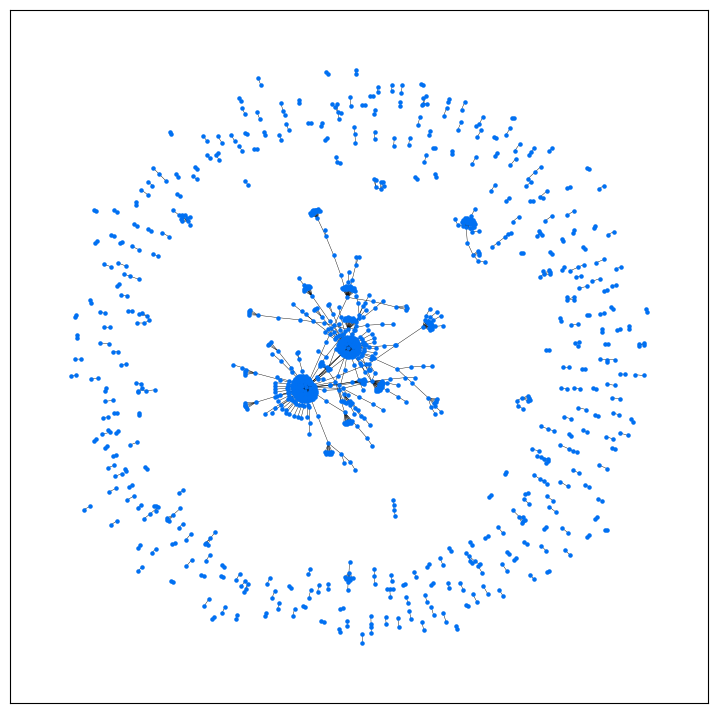

In [14]:
plt.figure(figsize=(9,9)) 

G = nx.Graph()
G.add_edges_from(edges_list)
nx.draw_networkx(G,  with_labels=False, 
                     node_size=5, 
                     width=0.3, 
                     node_color="#0070F2")

plt.show()